In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.io

In [60]:
# function to read matlab .mat files
def read_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    data = ['fp1', 'fp2', 'fp3']
    columns = ['fx', 'fy', 'fz', 'cop_x', 'cop_y', 'cop_z']

    fp_1 = pd.DataFrame(mat[data[0]], columns=columns)
    fp_2 = pd.DataFrame(mat[data[1]], columns=columns)
    fp_3 = pd.DataFrame(mat[data[2]], columns=columns)

    return fp_1, fp_2, fp_3


In [61]:
# define flags
flag = 'plank'  # options: 'gait' or 'plank'

fp1, fp2, fp3 = read_mat_file(f'Dynamic Analysis/{flag}/{flag}_f.mat')

# # drop fz and cop_z columns
# fp1 = fp1.drop(columns=['cop_y'])
# fp2 = fp2.drop(columns=['cop_y'])
# fp3 = fp3.drop(columns=['cop_y'])
#
# print(fp1.head())
# print(fp2.head())
# print(fp3.head())

In [62]:
def get_rise_and_drop_indices(fpz, threshold=5):
    '''
    Identify the first index where the force rises above a threshold and the subsequent index where it drops below the threshold.
    '''

    above = fpz > threshold
    rise_indices = np.where(above)[0]
    if len(rise_indices) == 0:
        return None, None

    rise_index = rise_indices[0]
    below = fpz < threshold
    drop_indices = np.where(below & (np.arange(len(fpz)) > rise_index))[0]
    drop_index = drop_indices[0] if len(drop_indices) > 0 else None
    return rise_index, drop_index

def truncate_series(series, rise_index, drop_index, is_force=True):
    '''
    Truncate a pandas Series based on rise and drop indices.
    If is_force is True, set values before rise_index and after drop_index to 0.
    If is_force is False, set values before rise_index to NaN and after drop_index to the last valid value before drop_index.
    '''

    result = series.copy()
    if rise_index is None:
        if is_force:
            result[:] = 0
        else:
            result[:] = np.nan
        return result
    if is_force:
        result[:rise_index] = 0
        if drop_index is not None:
            result[drop_index:] = 0
    else:
        rise_val = result.iloc[rise_index]
        result.iloc[:rise_index] = rise_val
        if drop_index is not None:
            last_valid = result.iloc[drop_index - 1] if drop_index > 0 else result.iloc[0]
            result[drop_index:] = last_valid
    return result

In [63]:
force_threshold = 5  # Newtons
fps = [fp1, fp2, fp3]
fps_trunc = []

for fp in fps:
    rise_idx, drop_idx = get_rise_and_drop_indices(fp['fz'], threshold=force_threshold)
    fp_trunc = fp.copy()
    # Truncate force columns
    for col in ['fx', 'fy', 'fz']:
        fp_trunc[col] = truncate_series(fp[col], rise_idx, drop_idx, is_force=True)
    # Truncate CoP columns
    for col in ['cop_x', 'cop_y']:
        fp_trunc[col] = truncate_series(fp[col], rise_idx, drop_idx, is_force=False)
    fps_trunc.append(fp_trunc)

303 303


<Axes: title={'center': 'Force Plate 1 Fz Truncated'}, xlabel='Sample', ylabel='Force (N)'>

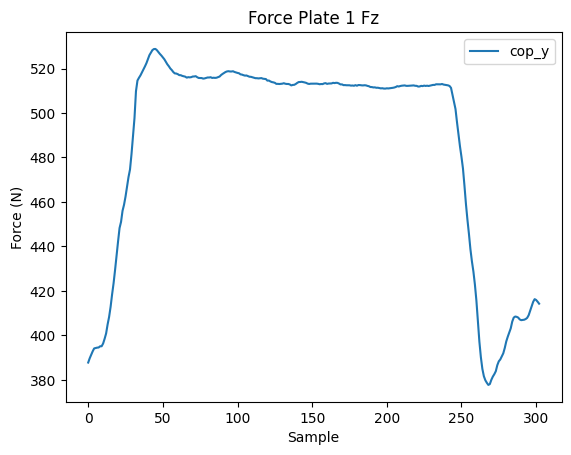

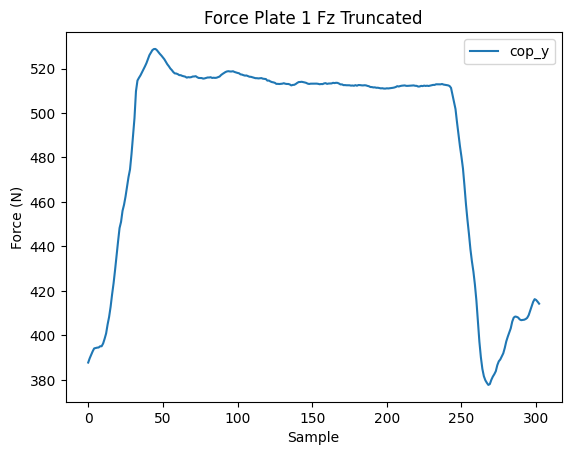

In [64]:
fp1_trunc = fps_trunc[0]
fp2_trunc = fps_trunc[1]
fp3_trunc = fps_trunc[2]

fp3.plot(y=['cop_y'], title='Force Plate 1 Fz', xlabel='Sample', ylabel='Force (N)')
print(len(fp1_trunc), len(fps[1]))


fp3_trunc.plot(y=['cop_y'], title='Force Plate 1 Fz Truncated', xlabel='Sample', ylabel='Force (N)')

In [65]:
def filter_data(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    if cutoff >= nyquist:
        return data
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
298   NaN
299   NaN
300   NaN
301   NaN
302   NaN
Name: cop_y, Length: 303, dtype: float64


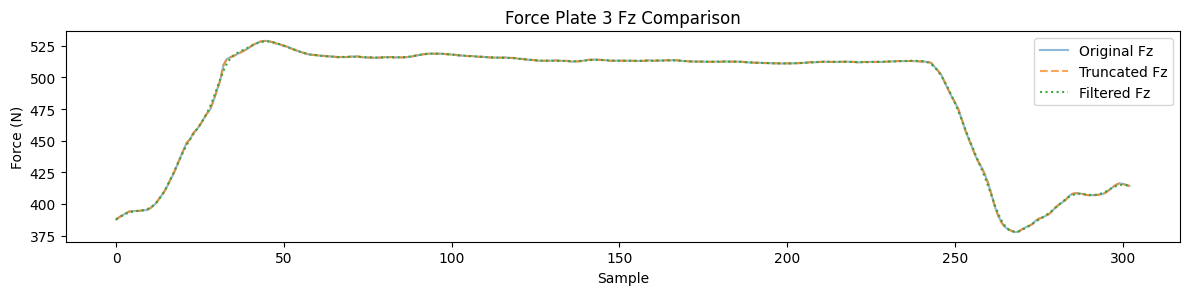

In [66]:
# --- Filter Specifications ---
fc_force = 20   # Hz
fc_cop = 10     # Hz
fs = 100.0  # Hz
order = 2   # Second-order Butterworth filter

# copy truncated data for comparison
fps_filtered = [fp.copy() for fp in fps_trunc]

# Apply filtering to truncated data
for fp in fps_filtered:
    for col in ['fx', 'fy', 'fz']:
        fp[col] = filter_data(fp[col], fc_force, fs, order)
    for col in ['cop_x', 'cop_y']:
        fp[col] = filter_data(fp[col], fc_cop, fs, order)

fp1_filt = fps_filtered[0]
fp2_filt = fps_filtered[1]
fp3_filt = fps_filtered[2]

print(fp2_filt['cop_y'])

# Plot original, truncated, and filtered data for comparison
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(fp3['cop_y'], label='Original Fz', alpha=0.5)
plt.plot(fp3_trunc['cop_y'], label='Truncated Fz', alpha=0.7, linestyle='--')
plt.plot(fp3_filt['cop_y'], label='Filtered Fz', alpha=0.9, linestyle=':')
plt.title('Force Plate 3 Fz Comparison')
plt.xlabel('Sample')
plt.ylabel('Force (N)')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
time = np.arange(len(fp1)) / fs

# arange dataframe with time, fx, fz, column of 0, cop_x, cop_z for each fps
# store the data with 6 digit precision
def create_output_dataframe(fp, time):
    output_df = pd.DataFrame({
        'time': time,
        'fx': fp['fx'].round(6),
        'fz': fp['fz'].round(6),
        'zero_col': 0.0,
        'cop_x': fp['cop_x'].round(6),
        'cop_z': fp['cop_z'].round(6)
    })
    return output_df

fp1_output = create_output_dataframe(fp1_filt, time)
fp2_output = create_output_dataframe(fp2_filt, time)
fp3_output = create_output_dataframe(fp3_filt, time)

# save to txt files with space separator and no index or header
fp1_output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_1.txt', sep=' ', index=False, header=False)
fp2_output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_2.txt', sep=' ', index=False, header=False)
fp3_output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_3.txt', sep=' ', index=False, header=False)